In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/dataset/model2.zip"
extract_to = "/content/tmp_dataset"

# Unzip if not already extracted
if not os.path.isdir(extract_to):
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_to)

SOURCE_DATA_DIR = extract_to


In [ ]:
import os
import shutil
import random

# --- CONFIGURATION ---

# IMPORTANT: This should be the path to the folder that contains your sorted class folders
# (Acne, Benign_Mole, etc.) after you unzip the file.
SOURCE_DATA_DIR = '/content/tmp_dataset/dataset'

# This is where the new train/val/test folders will be created.
DESTINATION_DIR = '/content/final_split_data'

# The ratio for splitting the data. 80% for training, 10% for validation, 10% for testing.
SPLIT_RATIO = (0.8, 0.1, 0.1)

# --- SCRIPT LOGIC ---

print(f"🚀 Starting dataset split...")
print(f"Source data: {SOURCE_DATA_DIR}")
print(f"Destination: {DESTINATION_DIR}")

# Remove the destination directory if it already exists to ensure a clean start
if os.path.exists(DESTINATION_DIR):
    shutil.rmtree(DESTINATION_DIR)

try:
    # Get the list of class names from the source directory folders
    class_names = [d for d in os.listdir(SOURCE_DATA_DIR) if os.path.isdir(os.path.join(SOURCE_DATA_DIR, d))]
    if not class_names:
        raise FileNotFoundError(f"No class folders found in '{SOURCE_DATA_DIR}'. Please check the path.")

    print(f"Found {len(class_names)} classes: {class_names}")

    # Create the train, val, and test directories in the destination
    train_path = os.path.join(DESTINATION_DIR, 'train')
    val_path = os.path.join(DESTINATION_DIR, 'val')
    test_path = os.path.join(DESTINATION_DIR, 'test')
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(val_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    # Iterate over each class to split its images
    for class_name in class_names:
        print(f"  -> Processing class: {class_name}")

        # Create class subdirectories in train, val, and test
        os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_path, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

        # Get all image files for the current class
        source_class_path = os.path.join(SOURCE_DATA_DIR, class_name)
        images = [f for f in os.listdir(source_class_path) if os.path.isfile(os.path.join(source_class_path, f))]

        # Shuffle the images randomly
        random.shuffle(images)

        # Calculate split indices based on the ratio
        train_end = int(len(images) * SPLIT_RATIO[0])
        val_end = train_end + int(len(images) * SPLIT_RATIO[1])

        # Function to copy files to the correct destination
        def copy_files(file_list, split_folder_path):
            for img_file in file_list:
                src_path = os.path.join(source_class_path, img_file)
                dest_path = os.path.join(split_folder_path, class_name, img_file)
                shutil.copy2(src_path, dest_path)

        # Copy the files into their final train/val/test folders
        copy_files(images[:train_end], train_path)
        copy_files(images[train_end:val_end], val_path)
        copy_files(images[val_end:], test_path)

    print("\n✅ Data splitting complete!")

except Exception as e:
    print(f"❌ An error occurred: {e}")
    print("Please check that the SOURCE_DATA_DIR path is correct and contains your class folders.")

🚀 Starting dataset split...
Source data: /content/tmp_dataset/dataset
Destination: /content/final_split_data
Found 7 classes: ['Ringworm', 'Psoriasis', 'Benign_Mole', 'Eczema', 'Healthy_skin', 'Acne', 'Melanoma_Consumer']
  -> Processing class: Ringworm
  -> Processing class: Psoriasis
  -> Processing class: Benign_Mole
  -> Processing class: Eczema
  -> Processing class: Healthy_skin
  -> Processing class: Acne
  -> Processing class: Melanoma_Consumer

✅ Data splitting complete!


In [ ]:
# ==============================================================================
# The Ultimate SOTA-B4 Training Script (Consumer Model)
# DermaSense - June 18, 2025
#
# STRATEGY:
# 1. ARCHITECTURE: Upgrades to EfficientNetB4 for maximum feature extraction.
# 2. AUGMENTATION: Uses an aggressive, modern augmentation pipeline for robustness.
# 3. IMBALANCE HANDLING: Re-integrates Focal Loss and Class Weights, a critical
#    combination to force the model to learn rare but important classes.
# 4. FINE-TUNING: Employs a gradual unfreezing strategy for stable learning.
# 5. SAFETY: Saves the best model directly to Google Drive to prevent data loss.
# ==============================================================================

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from sklearn.utils import class_weight
from google.colab import drive
import numpy as np
import os

# ==============================================================================
# 0. SETUP AND PERMANENT STORAGE
# ==============================================================================

# Mount your drive FIRST to ensure access
drive.mount('/content/drive')

# --- CONFIGURATION ---
# Define paths for your consumer-grade dataset
data_dir = '/content/final_split_data'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# --- Hyperparameters ---
IMG_SIZE = 380 # Correct size for EfficientNetB4
BATCH_SIZE = 16 # Reduced batch size for B4's larger memory footprint
EPOCHS_INITIAL = 15
EPOCHS_FINE_TUNE = 35
learning_rate_initial = 1e-4
learning_rate_fine_tune = 1e-5

# --- PERMANENT SAVE PATH ON GOOGLE DRIVE ---
DRIVE_SAVE_PATH = "/content/drive/MyDrive/DermaSense_Models/"
MODEL_FILENAME = "sota_model_b4_consumer.keras"
MODEL_SAVE_PATH = os.path.join(DRIVE_SAVE_PATH, MODEL_FILENAME)

# Create the directory on Drive if it doesn't exist
os.makedirs(DRIVE_SAVE_PATH, exist_ok=True)
print(f"✅ Models will be saved to: {MODEL_SAVE_PATH}")

# ==============================================================================
# 1. DATA AUGMENTATION & GENERATORS
# ==============================================================================

# Using your new, more aggressive augmentation pipeline
train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.6, 1.4),
    shear_range=0.2,
    zoom_range=0.3,
    channel_shift_range=20,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Data Generators
print(" Setting up data generators...")
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# ==============================================================================
# 2. CLASS IMBALANCE HANDLING
# ==============================================================================

# CRITICAL: Calculate class weights to handle the imbalanced dataset
print("\n Calculating class weights...")
class_labels = train_gen.classes
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weight_dict = {i: w for i, w in enumerate(weights)}
print("Class weights calculated successfully:")
print(class_weight_dict)

# ==============================================================================
# 3. MODEL DEFINITION & SOTA LOSS FUNCTION
# ==============================================================================

# CRITICAL: Re-introducing Focal Loss to focus on hard-to-classify examples
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.gamma = gamma
    def call(self, y_true, y_pred):
        ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False)
        p_t = tf.exp(-ce)
        return tf.reduce_mean(self.alpha * tf.pow(1 - p_t, self.gamma) * ce)

# Model Initialization with EfficientNetB4
print("\n Building EfficientNetB4 model...")
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Classifier Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) # Aggressive dropout for regularization
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# ==============================================================================
# 4. CALLBACKS & COMPILATION
# ==============================================================================

# Using a slightly more patient set of callbacks for this larger model
callbacks = [
    ReduceLROnPlateau(monitor='val_accuracy', patience=4, factor=0.3, verbose=1, mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1, mode='max'),
    ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
]

# ==============================================================================
# 5. THE ULTIMATE TRAINING STRATEGY
# ==============================================================================

# --- Phase 1: Train with frozen base ---
print("\n Phase 1: Training classifier head...")
base_model.trainable = False

model.compile(optimizer=AdamW(learning_rate=learning_rate_initial),
              loss=FocalLoss(), # Using Focal Loss
              metrics=['accuracy', TopKCategoricalAccuracy(k=2, name='top_2_accuracy')])

model.fit(
    train_gen,
    epochs=EPOCHS_INITIAL,
    validation_data=val_gen,
    callbacks=callbacks,
    class_weight=class_weight_dict # Using Class Weights
)

# --- Phase 2: Fine-tuning deeper layers ---
print("\n🔧 Phase 2: Gradual unfreezing for fine-tuning...")
base_model.trainable = True

# Freeze first layers, fine-tune the deeper, more specialized ones
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=AdamW(learning_rate=learning_rate_fine_tune),
              loss=FocalLoss(), # Using Focal Loss
              metrics=['accuracy', TopKCategoricalAccuracy(k=2, name='top_2_accuracy')])

model.fit(
    train_gen,
    epochs=EPOCHS_INITIAL + EPOCHS_FINE_TUNE, # Continue epoch count
    validation_data=val_gen,
    callbacks=callbacks,
    initial_epoch=EPOCHS_INITIAL,
    class_weight=class_weight_dict # Using Class Weights
)

# ==============================================================================
# 6. FINAL EVALUATION
# ==============================================================================
print("\n" + "="*50 + "\n FINAL EVALUATION ON TEST SET\n" + "="*50)
print(f"Loading best model weights from '{MODEL_SAVE_PATH}'...")

# The EarlyStopping callback has already restored the best weights,
# but we load from the checkpoint file just to be absolutely certain.
try:
    model.load_weights(MODEL_SAVE_PATH)
except Exception as e:
    print(f"\nCould not load weights from file, proceeding with current model weights. Error: {e}")

test_gen = val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

scores = model.evaluate(test_gen, verbose=1)
print(f"\n Final Consumer Model Results:")
print(f"  - Test Accuracy (Top-1): {scores[1]*100:.2f}%")
print(f"  - Test Top-2 Accuracy:   {scores[2]*100:.2f}%")
print(f"  - Test Loss:             {scores[0]:.4f}")

print("\n ONE SHOT COMPLETE! ")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Models will be saved to: /content/drive/MyDrive/DermaSense_Models/sota_model_b4_consumer.keras
🧠 Setting up data generators...
Found 13836 images belonging to 7 classes.
Found 1727 images belonging to 7 classes.

⚖️ Calculating class weights...
Class weights calculated successfully:
{0: np.float64(0.6278816482120168), 1: np.float64(0.8446886446886447), 2: np.float64(1.1565660787427903), 3: np.float64(1.3697653697653698), 4: np.float64(4.017421602787456), 5: np.float64(0.781871609403255), 6: np.float64(0.9083508403361344)}

🏗️ Building EfficientNetB4 model...
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🎯 Phase 1: Training classifier head...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
865/865 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.3082 - loss: 0.3034 - top_2_accuracy: 0.5008

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.52750, saving model to /content/drive/MyDrive/DermaSense_Models/sota_model_b4_consumer.keras
865/865 ━━━━━━━━━━━━━━━━━━━━ 783s 847ms/step - accuracy: 0.3083 - loss: 0.3034 - top_2_accuracy: 0.5009 - val_accuracy: 0.5275 - val_loss: 0.2010 - val_top_2_accuracy: 0.7307 - learning_rate: 1.0000e-04
Epoch 2/15
865/865 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.5264 - loss: 0.2044 - top_2_accuracy: 0.7212
Epoch 2: val_accuracy improved from 0.52750 to 0.57730, saving model to /content/drive/MyDrive/DermaSense_Models/sota_model_b4_consumer.keras
865/865 ━━━━━━━━━━━━━━━━━━━━ 719s 783ms/step - accuracy: 0.5264 - loss: 0.2044 - top_2_accuracy: 0.7212 - val_accuracy: 0.5773 - val_loss: 0.1718 - val_top_2_accuracy: 0.7678 - learning_rate: 1.0000e-04
Epoch 3/15
865/865 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.5695 - loss: 0.1769 - top_2_accuracy: 0.7679
Epoch 3: val_accuracy improved from 0.57730 to 0.58599, saving model to /content/drive

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


109/109 ━━━━━━━━━━━━━━━━━━━━ 30s 277ms/step - accuracy: 0.8904 - loss: 0.0366 - top_2_accuracy: 0.9688

🏆 Final Consumer Model Results:
  - Test Accuracy (Top-1): 85.82%
  - Test Top-2 Accuracy:   96.25%
  - Test Loss:             0.0447

🚀 ONE SHOT COMPLETE! 🚀


🚀 Starting Analysis for model: sota_model_b4_consumer.keras

1. Loading model and test data generator...
   ✅ Model loaded successfully.
Found 1735 images belonging to 7 classes.

2. Generating predictions on the test set (this may take a moment)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 65s 741ms/step
   -> Found 7 classes: ['Acne', 'Benign_Mole', 'Eczema', 'Healthy_skin', 'Melanoma_Consumer', 'Psoriasis', 'Ringworm']

📊 3a. Standard Classification Report (Per-Class F1, etc.)
                   precision    recall  f1-score   support

             Acne     0.9543    0.9543    0.9543       394
      Benign_Mole     0.7430    0.8191    0.7792       293
           Eczema     0.7671    0.7814    0.7742       215
     Healthy_skin     0.9602    0.9337    0.9468       181
Melanoma_Consumer     0.4400    0.3548    0.3929        62
        Psoriasis     0.9119    0.9148    0.9134       317
         Ringworm     0.8784    0.8205    0.8485       273

         accuracy                         0.8582      1735
        macro avg     0.8079    0.7970    0.8013      1735
     weighted avg     0.8580    0.8582    0.8574      1735


🎯 3b. Overall Accuracy Metrics
   Top-1 Accuracy: 0.8582 (85.82%)
   Top-2 Accuracy: 0.9625 (96.25%)

🔬 4. Clinical Utility Met

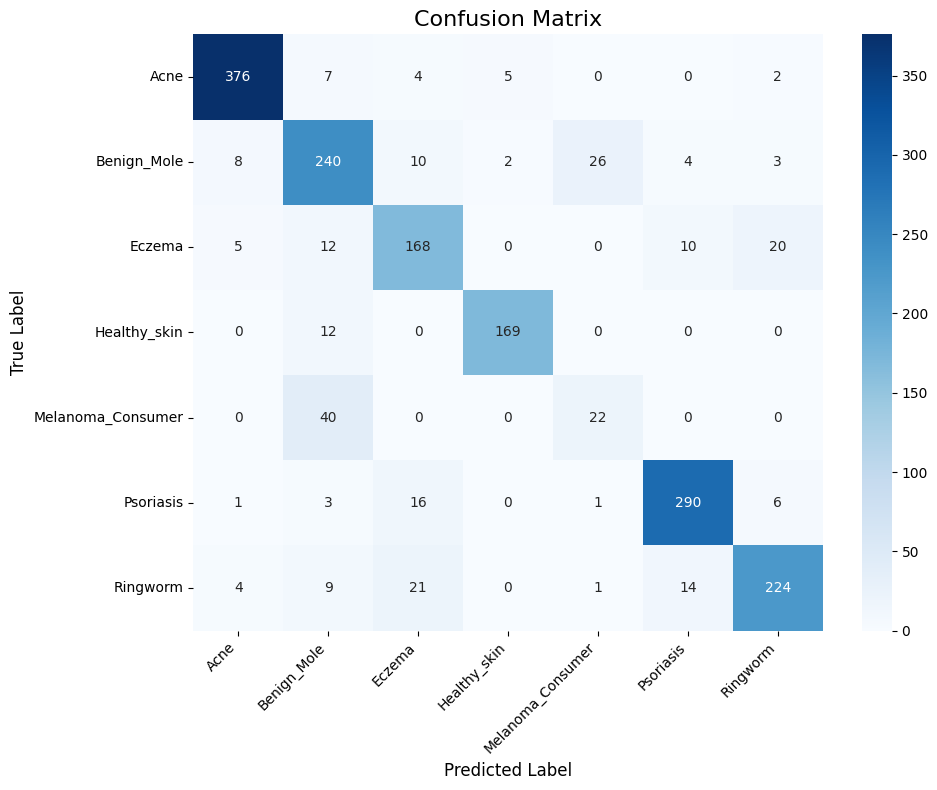


🏆 6. Final SOTA-Ready Metrics Summary
   Balanced Multi-Class Accuracy: 0.7970 (79.70%)
   Melanoma vs. Others AUC:         0.9572
   Melanoma Sensitivity (Recall):   0.3548
   Melanoma Specificity:            0.9833

🎉 Analysis Complete! 🎉


In [ ]:
# ==============================================================================
# DermaSense - Comprehensive Model Analysis Script
#
# INSTRUCTIONS:
# 1. Run this script in a Colab notebook after your model has finished training.
# 2. Ensure your final test dataset is in a '/content/final_split_data/test' directory.
# 3. Update the 'MODEL_TO_EVALUATE_PATH' variable to point to the specific .keras
#    file you want to analyze (e.g., your clinical B3 or consumer B4 model).
# ==============================================================================

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import TopKCategoricalAccuracy
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, top_k_accuracy_score, roc_auc_score, confusion_matrix

# --- CONFIGURATION ---
# IMPORTANT: Update these paths to match your project setup.

# Path to the specific saved model file you want to analyze
MODEL_TO_EVALUATE_PATH = '/content/drive/MyDrive/DermaSense_Models/sota_model_b4_consumer.keras'

# Path to the directory containing your test set
TEST_DIR = '/content/final_split_data/test'

# Model input image size (must match the model you are evaluating)
# For B3 Clinical Model: 300
# For B4 Consumer Model: 380
IMG_SIZE = 380
BATCH_SIZE = 32 # Use a standard batch size for evaluation

# --- SCRIPT START ---

print(f" Starting Analysis for model: {os.path.basename(MODEL_TO_EVALUATE_PATH)}")

# ==============================================================================
# 1. LOAD MODEL AND TEST DATA
# ==============================================================================

print("\n1. Loading model and test data generator...")

# Load the trained model
try:
    model = tf.keras.models.load_model(MODEL_TO_EVALUATE_PATH, compile=False)
    # Re-compile with the necessary metrics. The loss function doesn't matter for evaluation.
    model.compile(loss='categorical_crossentropy', metrics=['accuracy', TopKCategoricalAccuracy(k=2)])
    print("    Model loaded successfully.")
except Exception as e:
    print(f"    ERROR: Could not load the model. Please check the path. Error: {e}")
    exit()

# Create a data generator for the test set (only preprocessing is needed)
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # IMPORTANT: Do not shuffle the test set
)

# ==============================================================================
# 2. GET MODEL PREDICTIONS
# ==============================================================================
print("\n2. Generating predictions on the test set (this may take a moment)...")

# Get the predicted probabilities for each image in the test set
pred_probs = model.predict(test_generator, verbose=1)

# Get the true class labels from the generator
y_true = test_generator.classes

# Get the class names in the correct order from the generator
class_names = list(test_generator.class_indices.keys())
print(f"   -> Found {len(class_names)} classes: {class_names}")

# Get the Top-1 prediction index for each sample
y_pred_top1 = np.argmax(pred_probs, axis=1)

# ==============================================================================
# 3. DETAILED PERFORMANCE METRICS
# ==============================================================================

# --- Per-Class F1-Scores, Precision, and Recall ---
print("\n" + "="*60)
print("📊 3a. Standard Classification Report (Per-Class F1, etc.)")
print("="*60)
# The 'f1-score' column contains the requested metric for each class.
# We save the report as a dictionary to extract metrics later.
report_dict = classification_report(y_true, y_pred_top1, target_names=class_names, digits=4, output_dict=True)
print(classification_report(y_true, y_pred_top1, target_names=class_names, digits=4))

# --- Overall Accuracy Metrics ---
print("\n" + "="*60)
print(" 3b. Overall Accuracy Metrics")
print("="*60)
top1_accuracy = accuracy_score(y_true, y_pred_top1)
top2_accuracy = top_k_accuracy_score(y_true, pred_probs, k=2, labels=np.arange(len(class_names)))
print(f"   Top-1 Accuracy: {top1_accuracy:.4f} ({top1_accuracy*100:.2f}%)")
print(f"   Top-2 Accuracy: {top2_accuracy:.4f} ({top2_accuracy*100:.2f}%)")


# ==============================================================================
# 4. CLINICAL UTILITY METRICS FOR MELANOMA (SOTA)
# ==============================================================================
print("\n" + "="*60)
print(" 4. Clinical Utility Metrics for Melanoma Detection (SOTA)")
print("="*60)

# Find the class index for melanoma (handle both possible names)
melanoma_label = 'Melanoma_Consumer' if 'Melanoma_Consumer' in class_names else 'melanoma'
if melanoma_label in class_names:
    melanoma_idx = test_generator.class_indices[melanoma_label]
    print(f"   -> Melanoma class ('{melanoma_label}') found at index: {melanoma_idx}")

    # Create binary true labels (1 for melanoma, 0 for others)
    y_true_binary = (y_true == melanoma_idx).astype(int)

    # Get the predicted probabilities for the melanoma class
    y_scores_melanoma = pred_probs[:, melanoma_idx]

    # --- Calculate AUC ---
    try:
        auc = roc_auc_score(y_true_binary, y_scores_melanoma)
        print(f"   Melanoma vs. Others AUC: {auc:.4f}")
    except ValueError as e:
        print(f"   Could not calculate AUC: {e}")
        auc = 0

    # --- Calculate Sensitivity & Specificity ---
    tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_top1 == melanoma_idx).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"   Melanoma Sensitivity (Recall): {sensitivity:.4f}")
    print(f"   Melanoma Specificity:        {specificity:.4f}")

else:
    print("    Could not find 'melanoma' or 'Melanoma_Consumer' class to calculate clinical metrics.")
    melanoma_idx = None

# ==============================================================================
# 5. VISUALIZATIONS
# ==============================================================================
print("\n" + "="*60)
print("📈 5. Confusion Matrix Visualization")
print("="*60)

cm = confusion_matrix(y_true, y_pred_top1)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# ==============================================================================
# 6. FINAL SOTA-READY METRICS SUMMARY
# ==============================================================================
print("\n" + "="*60)
print("🏆 6. Final SOTA-Ready Metrics Summary")
print("="*60)

# Balanced Accuracy is the macro average of the recall scores
balanced_accuracy = report_dict['macro avg']['recall']

print(f"   Balanced Multi-Class Accuracy: {balanced_accuracy:.4f} ({balanced_accuracy*100:.2f}%)")
if melanoma_idx is not None:
    print(f"   Melanoma vs. Others AUC:         {auc:.4f}")
    print(f"   Melanoma Sensitivity (Recall):   {sensitivity:.4f}")
    print(f"   Melanoma Specificity:            {specificity:.4f}")

print("\n Analysis Complete! ")